In [101]:
"""
    Authors: 
        Ali Karimiafshar <karimiafsharali@gmail.com>
        Vitor Freitas <vit1905@live.missouristate.edu>
        Kadidia Kantao
    Date:
        12/09/2021
    Dataset:
        https://www.kaggle.com/c/digit-recognizer/data
""";

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [103]:
# Read the data and display the first seven elements.
data = pd.read_csv("train.csv")
data.head(7)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
# Convert data to numpy array
data = np.array(data)

# Divide the data in two groups for training (80%) and testing (20%).
dataSampleSize, features = data.shape
splitPoint = int(dataSampleSize*0.80)

# Transpose the data so that each column corresponds with a new sample and each rwo with the pixel values.
# Normalize the pixel values to a range [0, 1].
data_train = data[:splitPoint].T
X_train = data_train[1:] / 255
Y_train = data_train[0]

data_cross = data[splitPoint:].T
X_cross = data_cross[1:] / 255
Y_cross = data_cross[0]

In [105]:
class NeuralNetworkLayer:
    def __init__(self, cur_num_neurons:int, next_num_neurons:int=10) -> None:
        """ A Neural Network Layer that creates weights and biases arrays for the Neural Network \
            according to the number of neurons in the current layer and the next layer.

        Args:
            cur_num_neurons (int): Number of neurons on the current layer. Weights matrix columns.
            next_num_neurons (int, optional): Number of neurons on the next layer. Weights matrix rows. Defaults to 10.
        """
        
        # Initial range of randoms weights and biases is [-0.50, 0.50].
        randRange = 0.5
        self.weights = np.random.uniform(-randRange, randRange, size=(next_num_neurons, cur_num_neurons))
        self.biases = np.random.uniform(-randRange, randRange, size=(next_num_neurons, 1))
        self.output = None
        self.output_activated = None
        
        
    def forward_prop(self, inputData:np.array) -> np.array:
        """ Forward propagation. Performs matrix multiplication between weights and input data, then adds biases.

        Args:
            inputData (np.array): Input data or output data from the last neuron layer.

        Returns:
            np.array: The matrix multiplication product of weights and inputData plus the bias
        """
        
        self.output = self.weights.dot(inputData) + self.biases
        return self.output
        
        
    def activation_ReLU(self) -> np.array:
        """ ReLU activation function.

        Returns:
            np.array: The forward propagation output, or zero, whichever is greater.
        """
        
        # Element-wise maximum comparison.
        self.output_activated = np.maximum(0, self.output)
        return self.output_activated
    
    
    def derivative_activation_ReLU(self) -> np.array:
        """ ReLU derivative used for backward propagation. 

        Returns:
            np.array: The derivative of the ReLU activation function, which is 1 when f>0, or 0 otherwise.
        """
        
        # Bool will be converted to 0 or 1 when type casting.
        return self.output_activated > 0
    
    
    def activation_softmax(self) -> np.array:
        """ Softmax activation function.

        Returns:
            np.array: The matrix prediction of the model based on the input data, weights, and biases of the Neural Network Layers. 
        """
        
        # Element-wise exponential function divided by the sum of all exponential functions e^x.
        self.output_activated = np.exp(self.output) / sum(np.exp(self.output))
        return self.output_activated
    
    
    def update_weights_biases(self, dW:np.array, dB:float, alpha:float) -> None:
        """ Updates the weights and biases of the neural network layer based on the back propagation calculations.

        Args:
            dW (np.array): Change in weights.
            dB (float): Change in biases.
            alpha (float): Learning rate.
        """
        
        self.weights -= alpha * dW
        self.biases -= alpha * dB

In [106]:
class DigitRecognizerNeuralNetwork:
    def __init__(self, X:np.array, Y:np.array, SampleSize:int, iterations:int=500, alpha:float=0.10) -> None:
        """ The Neural Network designed to classify handwriting digit samples found in the Kaggle dataset. 

        Args:
            X (np.array): The training or testing data. Excludes the label.
            Y (np.array): The data label.
            SampleSize (int): Size of the dataset.
            iterations (int, optional): Number of times the neural network is trained on the training dataset. Defaults to 500.
            alpha (float, optional): Learning rate. Defaults to 0.10.
        """
        
        self.hiddenLayer = NeuralNetworkLayer(784,10)
        self.outputLayer = NeuralNetworkLayer(10,10)
        
        self.X = X
        self.Y = Y
        
        self.size = SampleSize
        self.alpha = alpha
        self.iterations = iterations
        
        self.gradient_descent()
            

    def forward_prop(self):
        hiddenLayer_output = self.hiddenLayer.forward_prop(self.X)
        hiddenLayer_activated = self.hiddenLayer.activation_ReLU()
        
        outputLayer_output = self.outputLayer.forward_prop(hiddenLayer_activated)
        outputLayer_activated = self.outputLayer.activation_softmax()
        
        return hiddenLayer_output, hiddenLayer_activated, outputLayer_output, outputLayer_activated
        
            
    def get_actual_label(self, Y):
        actual_y = np.zeros((Y.size, 10))
        actual_y[[i for i in range(Y.size)], Y] = 1
        return actual_y.T
    
    
    def backward_prop(self):
        actual_y = self.get_actual_label(self.Y)
        dZ_outputLayer = self.outputLayer.output_activated - actual_y
        dW_outputLayer = 1 / self.size * dZ_outputLayer.dot(self.hiddenLayer.output_activated.T)
        db_outputLayer = 1 / self.size * np.sum(dZ_outputLayer)
        
        dZ_hiddenLayer = self.outputLayer.weights.T.dot(dZ_outputLayer) * self.hiddenLayer.derivative_activation_ReLU()
        dW_hiddenLayer = 1 / self.size * dZ_hiddenLayer.dot(self.X.T)
        db_hiddenLayer = 1 / self.size * np.sum(dZ_hiddenLayer)
        
        
        self.outputLayer.update_weights_biases(dW_outputLayer, db_outputLayer, self.alpha)
        self.hiddenLayer.update_weights_biases(dW_hiddenLayer, db_hiddenLayer, self.alpha)
        
        # return dW_hiddenLayer, db_hiddenLayer, dW_outputLayer, db_outputLayer

    def get_predictions(self, A2):
        return np.argmax(A2, 0)

    def get_accuracy(self, predictions, Y):
        print(predictions, Y)
        return np.sum(predictions == Y) / Y.size
    
    def gradient_descent(self):
        for i in range(self.iterations):
            Z1, A1, Z2, A2 = self.forward_prop()
            self.backward_prop()
            # self.Z1, self.Z1_activated, self.Z2, self.Z2_activated = self.forward_prop()
            if i == 23:
                temp = 2
                temp += 10
            if (i % 10) == 0 or i == self.iterations - 1:
                self.NNoutput = self.outputLayer.output
                predictions = self.get_predictions(self.NNoutput)
                print(f"iteration: {i}\nAccuracy: {self.get_accuracy(predictions, self.Y)}")

In [107]:
a = DigitRecognizerNeuralNetwork(X_train, Y_train, dataSampleSize, 1000, 0.10)

[3 1 1 ... 5 1 8] [1 0 1 ... 0 2 2]
iteration: 0
Accuracy: 0.13014880952380953
[3 8 6 ... 5 1 0] [1 0 1 ... 0 2 2]
iteration: 10
Accuracy: 0.22723214285714285
[3 8 1 ... 0 1 0] [1 0 1 ... 0 2 2]
iteration: 20
Accuracy: 0.352827380952381
[3 8 1 ... 0 1 0] [1 0 1 ... 0 2 2]
iteration: 30
Accuracy: 0.44151785714285713
[1 0 1 ... 0 1 6] [1 0 1 ... 0 2 2]
iteration: 40
Accuracy: 0.49547619047619046
[1 0 1 ... 0 1 6] [1 0 1 ... 0 2 2]
iteration: 50
Accuracy: 0.5325892857142858
[1 0 1 ... 0 1 2] [1 0 1 ... 0 2 2]
iteration: 60
Accuracy: 0.5625297619047619
[1 0 1 ... 0 1 2] [1 0 1 ... 0 2 2]
iteration: 70
Accuracy: 0.5877380952380953
[1 0 1 ... 0 1 2] [1 0 1 ... 0 2 2]
iteration: 80
Accuracy: 0.6089583333333334
[1 0 1 ... 0 1 2] [1 0 1 ... 0 2 2]
iteration: 90
Accuracy: 0.62625
[1 0 1 ... 0 1 2] [1 0 1 ... 0 2 2]
iteration: 100
Accuracy: 0.6410416666666666
[1 0 1 ... 0 1 2] [1 0 1 ... 0 2 2]
iteration: 110
Accuracy: 0.6544047619047619
[1 0 1 ... 0 6 2] [1 0 1 ... 0 2 2]
iteration: 120
Accuracy

Label: 7	Prediction:7

Label: 5	Prediction:6

Label: 8	Prediction:8

Label: 6	Prediction:0

Label: 2	Prediction:2

Label: 0	Prediction:0

Label: 2	Prediction:2



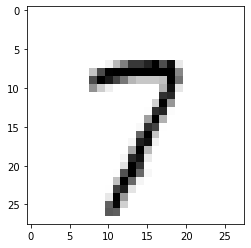

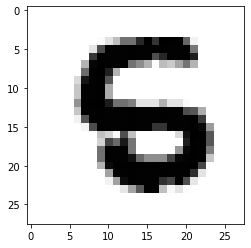

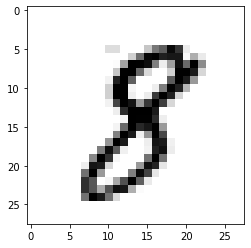

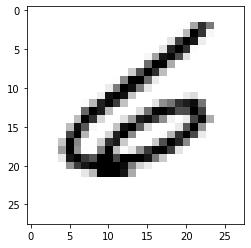

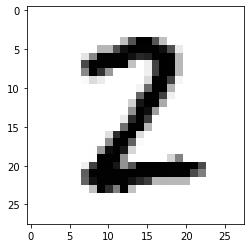

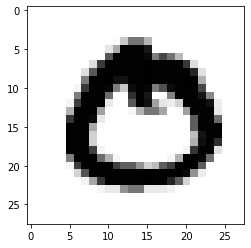

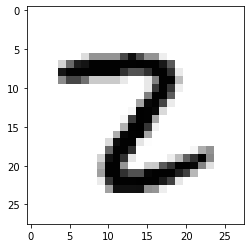

In [108]:
for n in range(18, 25):
    # n = 1
    # print(X_train[:,n].shape)
    digit = X_train[:,n].reshape(28, 28)
    plt.figure()
    plt.imshow(digit, plt.cm.gray_r)
    out = a.NNoutput[:,0]
    Y_train[n]
    pred = a.get_predictions(a.NNoutput)
    print(f"Label: {Y_train[n]}\tPrediction:{pred[n]}\n")

In [109]:
def display_sample(sample_index, X, Y, network_outcome):
    predicted_digit = np.argmax(network_outcome, 0)
    digit = X[:,n].reshape(28, 28)
    print(f"Label: {Y[n]}\tPrediction:{predicted_digit}\n")
    plt.imshow(digit, plt.cm.gray_r)

Label: 2	Prediction:1



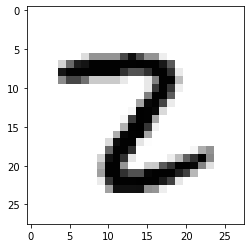

In [110]:
display_sample(9, X_train, Y_train, out)